In [1]:
!python --version

Python 3.10.5


In [2]:
#Preprocessing code borrowed from Fabrizio Ravelli: https://www.kaggle.com/code/fabrizioravelli/alzheimer-s-disease-classification-98-acc

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MILD_DEMENTED", "NON_DEMENTED", "VERYMILD_DEMENTED")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|█████████████████| 224/224 [00:00<00:00, 788.11it/s]


MILD_DEMENTED 0
NON_DEMENTED 1
VERYMILD_DEMENTED 2


Text(0.5, 0, 'Mild Demented')

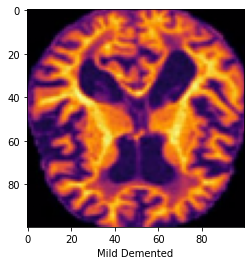

In [3]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

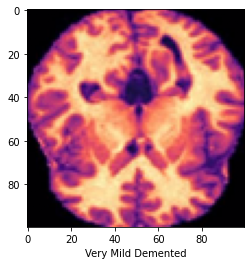

In [4]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

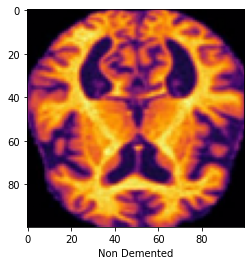

In [5]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [21]:
X_train.shape[1:]

(100, 100, 3)

In [6]:
from keras.models import load_model

model =load_model('movelv11_100epochs')

model.summary()

2022-08-23 09:51:31.627727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 09:51:31.689320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 09:51:31.691628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 09:51:31.694469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "modelv3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 98, 98, 32)   896         ['input_8[0][0]']                
                                                                                                  
 average_pooling2d_62 (AverageP  (None, 49, 49, 32)  0           ['conv2d_64[0][0]']              
 ooling2D)                                                                                        
                                                                                            

In [7]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

2022-08-23 09:51:42.068640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


20/20 [==============================] - 4s 32ms/step - loss: 0.0421 - acc: 0.9905 - prec: 0.9905 - rec: 0.9905 - auc: 0.9975
Testing Loss: 4.21%
Testing Accuracy: 99.05%
Testing Precision: 99.05%
Testing Recall: 99.05%
Testing AUC: 99.75%


In [8]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

20/20 [==============================] - 0s 15ms/step


In [9]:
cm

array([[ 89,   0,   0],
       [  0, 315,   5],
       [  0,   1, 223]])

In [11]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.984375   0.015625  ]
 [0.         0.00446429 0.99553571]]


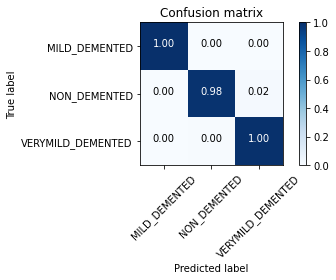

In [12]:
plot_confusion_matrix(cm, CLASSES, normalize=True)

In [15]:
biclass = ['NON_DEMENTED', 'DEMENTED']

bicm = np.array([[315, 5],
         [1,89 + 223]])

Normalized confusion matrix
[[0.984375   0.015625  ]
 [0.00319489 0.99680511]]


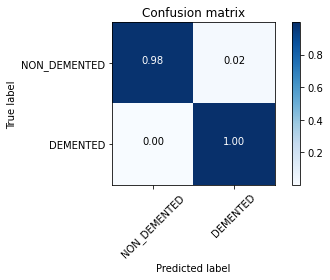

In [16]:
plot_confusion_matrix(bicm, biclass, normalize=True)

In [19]:
biacc = (315 + 223 + 89) / (315+5+1+89+223)

In [20]:
biacc

0.990521327014218

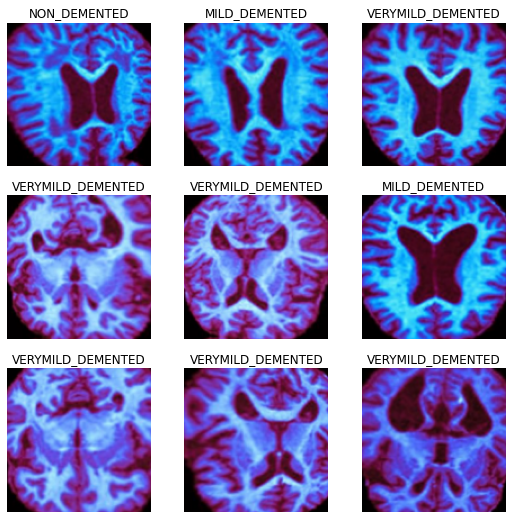

In [9]:
from fastai.vision.all import *

dls = ImageDataLoaders.from_folder(TEST_DIR, valid_pct=0.2, seed=30,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=9)